In [34]:
import numpy as np                         
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
import pandas as pd
from pykat.parallel import parakat

%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

In [36]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 -34 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
#Rc=2013.35 so that the loss is 1ppm
cav cavity ITM n2 ETM n3
attr ITM Rc -1934.0
attr ETM Rc 2245.0

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [37]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 20.7 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.484123 0
tem laser 5 1 0.395285 -90
tem laser 4 2 0.125 0
tem laser 3 3 0.433013 270
tem laser 2 4 0.125 180
tem laser 1 5 0.395285 -90
tem laser 0 6 0.484123 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -1934.0
attr ETM Rc 2245.0


pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [38]:
kat1 = katHG33.deepcopy()
kat1.parse("""
        pd Ptrans n4
        map ETM zernikeMapsOrder1/Z22order0phasemap.txt
        """)
kat1.noxaxis = True
out1=kat1.run()
Power=out1["Ptrans"]


pk2=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        kat2 = katHG33.deepcopy()
        kat2.parse("""
                map ETM zernikeMapsOrder1/Z{}{}order1phasemap.txt
                ad AD33 3 3 0 n4
                """.format(n,m))
        kat2.noxaxis = True
        pk2.run(kat2)
out2 = pk2.getResults()

lossZnm=[]
for i in range(28):
    loss=1 - np.abs(out2[i]['AD33'])**2/Power
    lossZnm.append(loss)

Parallel jobs: 100%|##########################################################|

In [42]:
pd.Series(lossZnm).to_pickle('pkl/HG33lossZnm.pkl')

In [43]:
katLG1 = katLG22.deepcopy()
katLG1.parse("""
        pd Ptrans n4
        map ETM zernikeMapsOrder1/Z22order0phasemap.txt
        """)
katLG1.noxaxis = True
outLG1=katLG1.run()
PowerLG=outLG1["Ptrans"]


pkLG2=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        katLG2 = katLG22.deepcopy()
        katLG2.parse("""
                map ETM zernikeMapsOrder1/Z{}{}order1phasemap.txt
                ad AD33 3 3 0 n4
                ad AD60 6 0 0 n4
                ad AD51 5 1 0 n4
                ad AD42 4 2 0 n4
                ad AD24 2 4 0 n4
                ad AD15 1 5 0 n4
                ad AD06 0 6 0 n4
                """.format(n,m))
        katLG2.noxaxis = True
        pkLG2.run(katLG2)
outLG2 = pkLG2.getResults()

LGlossZnm=[]
for i in range(28):
    mode=0.484123*outLG2[i]['AD06']-0.395285*1j*outLG2[i]['AD15']-0.125*(1j)**2*outLG2[i]['AD24'] \
    +0.433013*(1j)**3*outLG2[i]['AD33']-0.125*(1j)**4*outLG2[i]['AD42']-0.395285*(1j)**5*outLG2[i]['AD51'] \
    +0.484123*(1j)**6*outLG2[i]['AD60']
    loss=1-np.abs(mode)**2/PowerLG
    LGlossZnm.append(loss)

Parallel jobs: 100%|##########################################################|

In [47]:
pd.Series(LGlossZnm).to_pickle('pkl/LG22lossZnm.pkl')

In [52]:
HG33lossZnm_array=pd.read_pickle('pkl/HG33lossZnm.pkl').values
LG22lossZnm_array=pd.read_pickle('pkl/LG22lossZnm.pkl').values

(0.7571, 0.75735)

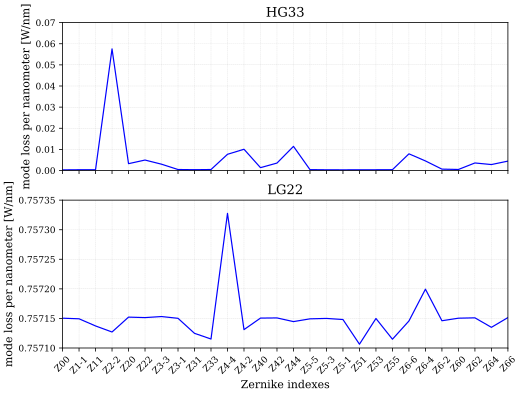

In [55]:
xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,(ax1,ax2) =plt.subplots(2,1,figsize=(8,6),sharex=True)
ax1.plot(HG33lossZnm_array)
ax1.set_ylabel("mode loss per nanometer [W/nm]")
ax1.set_title("HG33")
ax1.set_ylim(0,0.07)
ax1.set_xticks(range(28))
ax1.set_xticklabels(xticks,rotation=45, fontsize=9)

ax2.plot(LG22lossZnm_array)
ax2.set_ylabel("mode loss per nanometer [W/nm]")
ax2.set_xlabel('Zernike indexes')
ax2.set_ylabel('mode loss per nanometer [W/nm]')
ax2.set_title("LG22")
ax2.set_xticks(range(28))
ax2.set_xticklabels(xticks,rotation=45, fontsize=9)
ax2.set_ylim(0.7571,0.75735)

In [31]:
np.log(1)

0.0